# Pneumonia Detection Assignment

**Capstone Project**

*Team* - <br>
    Sajag Goel <br>
    Shubham Gajbhiye <br>
    Ramya Nagarajan <br>

# Table of Contents

I Problem Statement

II Exploratory Data Analysis

III Model Approach

IV Description of Models

V Model Improvements

VI Summary of Preliminary Results



## I. Problem
For Pneumonia detection, we need to detect Inflammation of the lungs. To build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiograp

## Business Value Proposition
Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).

## II. Exploratory Data analysis and preprocessing

Visual displays are powerful when used well, so think carefully about the information to display.
- Include insightful visualization
- Display examples to input in your model
- Share and explain particularly meaningful features, interactions or summary of data
- Exploring the given Data files
- Understanding the structure of data
- Missing points in data
- Visualizing different patterns
- Dealing with missing values

### A. Importing Libraries

In [134]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
import cv2
import json
import os
from imgaug import augmenters as iaa
from tqdm import notebook
from tqdm import tqdm
import pandas_profiling
import pydicom as dcm

%matplotlib inline 

### B. Defining the path and tables (from csv files)

In [2]:
## Defining the Path
cwd = os.getcwd()
PATH=cwd + "\input\\rsna-pneumonia-detection-challenge"
model_directory = cwd + "\model"

print("path of the Project Data :" ,PATH)
print("path of the Project Model :" ,model_directory)

path of the Project Data : D:\greatlakes\CAPSTONE\input\rsna-pneumonia-detection-challenge
path of the Project Model : D:\greatlakes\CAPSTONE\model


In [3]:
## Reading the csv files
class_info_dataframe = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_dataframe = pd.read_csv(PATH+'/stage_2_train_labels.csv')    

In [4]:
## Shape of the files
print("Shape of Class info is : ",class_info_dataframe.shape)
print("  .        .        .        .        .        .")
print("Shape of train labels is : ",train_labels_dataframe.shape)

Shape of Class info is :  (30227, 2)
  .        .        .        .        .        .
Shape of train labels is :  (30227, 6)


In [5]:
## 5 samples of class info file

class_info_dataframe.sample(5)

patientId                         class
16025  9b79a98f-a665-42ab-a74f-1fb5bc355247  No Lung Opacity / Not Normal
8299   5e5069e4-1f37-4fef-93d1-9b0162183277  No Lung Opacity / Not Normal
27734  f61c2271-a0f0-4a88-a803-71bd7dba0be9                  Lung Opacity
18793  b053417c-836f-4f6f-9224-f9dc286ee6d0                  Lung Opacity
6201   4d0aea20-5154-47c6-b948-99c1f47220cf  No Lung Opacity / Not Normal

In [6]:
## 5 samples of train label file
train_labels_dataframe.sample(5)

patientId      x      y  width  height  \
19403  b44bd070-da9f-479d-8546-9497dfc15762  257.0  277.0  239.0   270.0   
29404  14aee86e-0d8f-4fc3-b3ec-7ca26fc782bc    NaN    NaN    NaN     NaN   
22119  c857ee5f-f53c-4060-b93a-8c3437da80cd  247.0  434.0  247.0   265.0   
26569  ecbadacf-7590-4e97-be69-a4ca9e7a7d38    NaN    NaN    NaN     NaN   
19184  b2eca3cd-f9cc-46a6-b36a-2902558a7fc4  270.0  546.0  177.0   152.0   

       Target  
19403       1  
29404       0  
22119       1  
26569       0  
19184       1

class details info : Detailed information about the type of class associated with a certain patient.

Train Lables : Detailed information about the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

### C. Missing Data

In [7]:
## Missing Data from training labels

def data_missing_func(data):
    TOT = data.isnull().sum().sort_values(ascending = False)
    PERC = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([TOT, PERC], axis=1, keys=['Total', 'Percent']))

data_missing_func(train_labels_dataframe)

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

In [8]:
## Missing data from class info

data_missing_func(class_info_dataframe)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

all the parameters - heigh, width x y are missing when the target is 0, that is a person does not have pneumonia

### D. Class Distribution & Analysis

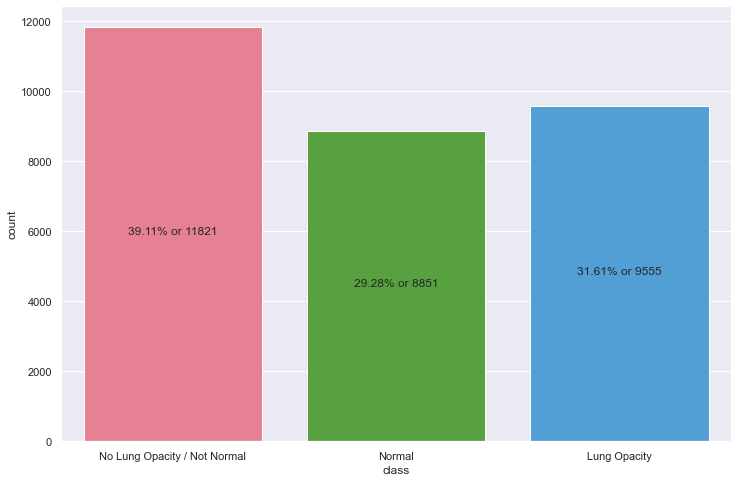

In [9]:
## CHeck class distribution


sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})

total = float(len(class_info_dataframe)) 
ax = sns.countplot(x="class", data=class_info_dataframe, palette='husl') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}% or {}'.format(100*height/total,height),
            ha="center") 
plt.show()

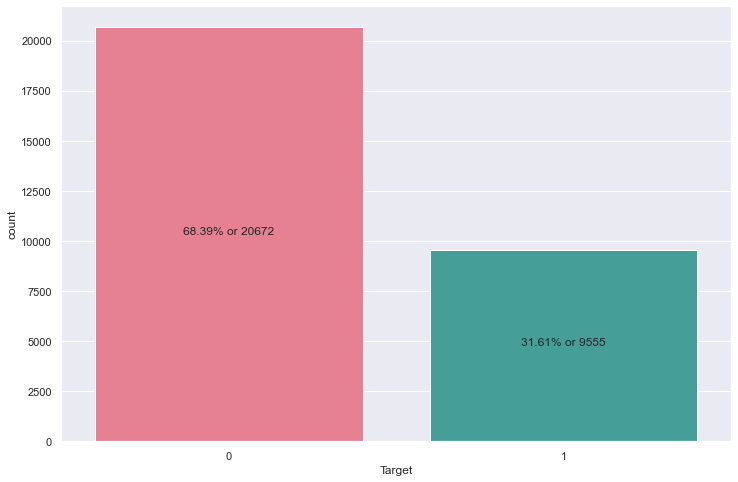

In [10]:
## CHeck class distribution


sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})

total = float(len(class_info_dataframe)) 
ax = sns.countplot(x="Target", data=train_labels_dataframe, palette='husl') 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.2f}% or {}'.format(100*height/total,height),
            ha="center") 
plt.show()

2 classes - No Lung Opacity  & Not Normal and Normal have the same percent (69.077%) as the percent of missing values for target window in class details information.

Also, the class Lung Opacity has the same percentage as the Target=1

### E. Merge Class and Target Data

In [11]:
train_class_dataframe = train_labels_dataframe.merge(class_info_dataframe, left_on='patientId', right_on='patientId', how='inner')

train_class_dataframe.sample(5)

patientId      x      y  width  height  \
22975  ae6974e6-b709-42bb-8076-ab8499929f09  239.0  601.0  237.0   171.0   
9020   515ab870-a80e-47f1-bd51-05a6fc02cba0  252.0  173.0  198.0   397.0   
8211   4bb131a0-02df-41fd-95e9-5db03457e75f    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
8915   507fff2d-4184-4da3-bd59-93af3fb307ec    NaN    NaN    NaN     NaN   

       Target                         class  
22975       1                  Lung Opacity  
9020        1                  Lung Opacity  
8211        0  No Lung Opacity / Not Normal  
1           0  No Lung Opacity / Not Normal  
8915        0  No Lung Opacity / Not Normal

In [12]:
# unique patrients in train data

print("Unique patientId is: ", train_class_dataframe['patientId'].nunique())

Unique patientId is:  26684


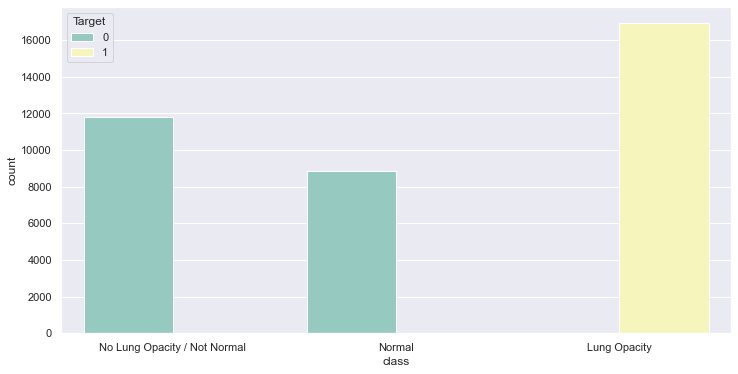

In [13]:
### Check calss distribution by target

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,6)})

total = float(len(train_class_dataframe))
ax = sns.countplot(x="class", data=train_class_dataframe,hue='Target', palette='Set3') 

plt.show()

As can be seen above only class Lung Opacity is part of the Target=1 else the other 2 classes are part of Target=0

<Figure size 864x432 with 0 Axes>

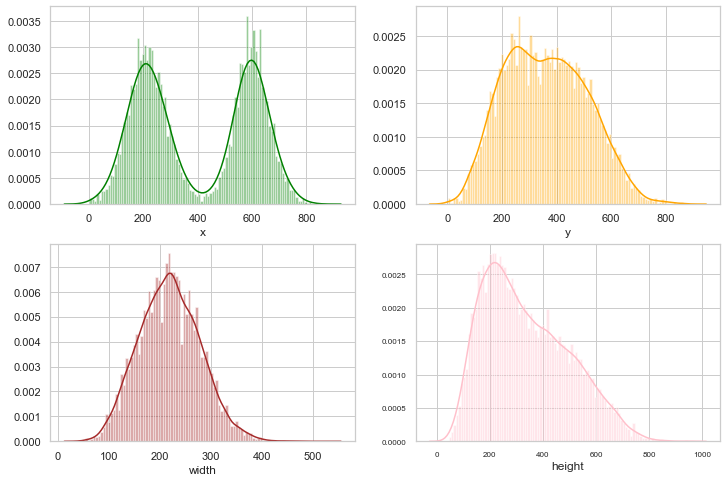

In [14]:
## Density of various columns for target = 1 (lung opacity class)

lung_opacity = train_class_dataframe[train_class_dataframe['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.distplot(lung_opacity['x'],kde=True,bins=100, color="green", ax=ax[0,0])
sns.distplot(lung_opacity['y'],kde=True,bins=100, color="orange", ax=ax[0,1])
sns.distplot(lung_opacity['width'],kde=True,bins=100, color="brown", ax=ax[1,0])
sns.distplot(lung_opacity['height'],kde=True,bins=100, color="pink", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=8)
plt.show()

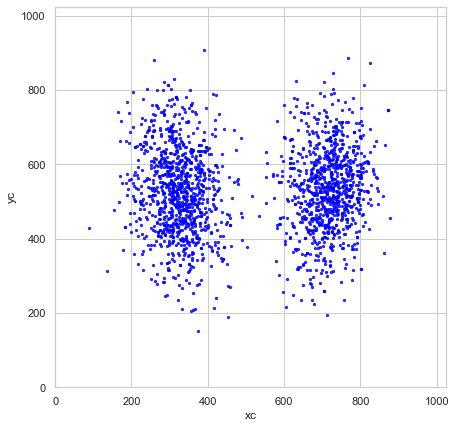

In [15]:
## Sample of center points superposed with the corresponding sample of the rectangles
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = lung_opacity.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="blue")

### F. DICOM Data 

In [16]:
image_train_path = (PATH+'/stage_2_train_images')
image_test_path = (PATH+'/stage_2_test_images')
image_train_path_dir = os.listdir(image_train_path)
image_test_path_dir = os.listdir(image_test_path )
print("Number of images in train set:", len(image_train_path_dir))
print("Number of images in test set:", len(image_test_path_dir))

Number of images in train set: 26684
Number of images in test set: 3000


As the number of images in train set is equal to unique patients in train data, its 1 to 1 mapping between patient id and images. Since the train data contains more rows than unique patient id, it means that for each patient id with lung opacity class, number of bounding boxes can be more than 1

In [17]:
## Calculating count of each patient id
patient_count = train_class_dataframe.groupby(['patientId'])['patientId'].count()

In [18]:
## Checking all entries with their respective count of each patient id

df = pd.DataFrame(data={'Patient_ID_Count': patient_count.values}, index=patient_count.index).reset_index()
final_val_cnt = df.groupby(['Patient_ID_Count']).count()
print("number of unique patients and their count of rows in data")
final_val_cnt

number of unique patients and their count of rows in data


patientId
Patient_ID_Count           
1                     23286
4                      3266
9                       119
16                       13

In [19]:
## Checking random image dcm data with target=1

print(lung_opacity.iloc[3])
patientId = lung_opacity['patientId'].iloc[3]
patientimg = patientId +'.dcm'
print(patientId)
print(patientimg)
imagepth = os.path.join(image_train_path,patientimg)
dcm_data=dcm.read_file(imagepth)
print(dcm_data)

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             562
y                                             152
width                                         256
height                                        453
Target                                          1
class                                Lung Opacity
Name: 7, dtype: object
00436515-870c-4b36-a041-de91049b9ab4
00436515-870c-4b36-a041-de91049b9ab4.dcm
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementat

In [20]:
#adding dicom data presnet in images to the dataset

## Columns that look important and are being added to the main data
cols_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

PATH2 = PATH + "\\"


## Writing function to add the dicom metadata

def extract_add_dicom_data(dataframe, path_d):
    for xyz in cols_to_add:
        dataframe[xyz] = None
        
    image_names = os.listdir(PATH2+path_d)
    
    for i, imgname in notebook.tqdm(enumerate(image_names)):
        imagePath = os.path.join(PATH2,path_d,imgname)
        datarowimg = dcm.read_file(imagePath)
        idx = (dataframe['patientId']==datarowimg.PatientID)
        dataframe.loc[idx,'ConversionType'] = datarowimg.ConversionType
        dataframe.loc[idx,'PatientAge'] = pd.to_numeric(datarowimg.PatientAge)
        dataframe.loc[idx,'Rows'] = datarowimg.Rows
        dataframe.loc[idx,'Modality'] = datarowimg.Modality
        dataframe.loc[idx,'BodyPartExamined'] = datarowimg.BodyPartExamined
        dataframe.loc[idx,'ViewPosition'] = datarowimg.ViewPosition
        dataframe.loc[idx,'Columns'] = datarowimg.Columns 
        dataframe.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",datarowimg.PixelSpacing[0])
        dataframe.loc[idx,'PatientSex'] = datarowimg.PatientSex 
        
## Calling the function to create final data including the metadata       
extract_add_dicom_data(train_class_dataframe,'stage_2_train_images\\')

In [21]:
## Checking the top 5 rows of the updated dataframe
train_class_dataframe.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality PatientAge PatientSex  \
0  No Lung Opacity / Not Normal       CR         51          F   
1  No Lung Opacity / Not Normal       CR         48          F   
2  No Lung Opacity / Not Normal       CR         19          M   
3                        Normal       CR         28          M   
4                  Lung Opacity       CR         32          F   

  BodyPartExamined ViewPosition ConversionType  Rows Columns PixelSpacing  
0            CHEST           PA            WSD  1024    1024        0.143  
1            CHEST           PA            WSD  1024    1024        0.194  
2            CHEST           AP            WSD  1024    1024        0.168  
3            CHEST           PA            WSD  1024    1024        0.143  
4            CHEST           AP            WSD  1024    1024        0.139

### G. DICOM Data - Basic Exploration of Variables


In [22]:
## Modality
print("Modalities : ",train_class_dataframe['Modality'].unique())

Modalities :  ['CR']


In [23]:
## Body Parts Examined
print("Body Part Examined : ",train_class_dataframe['BodyPartExamined'].unique())

Body Part Examined :  ['CHEST']


In [24]:
## POsition
print("View Position : ",train_class_dataframe['ViewPosition'].unique())


View Position :  ['PA' 'AP']


ViewPosition
AP    21817
PA    15812
Name: ViewPosition, dtype: int64


([<matplotlib.patches.Wedge at 0x14c70a7c198>,
 [Text(-0.27286327807178484, 1.0656198344062107, 'AP'),
  Text(0.2728633778423133, -1.0656198088589022, 'PA')],
 [Text(-0.1488345153118826, 0.5812471824033876, '58.0%'),
  Text(0.14883456973217085, -0.581247168468492, '42.0%')])

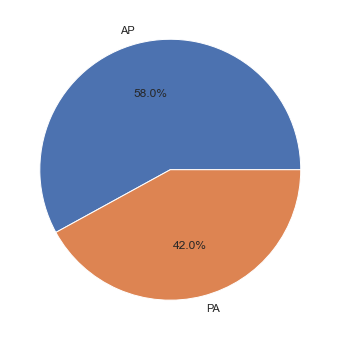

In [46]:
## Distrbution of View position
ViewPosition_count = train_class_dataframe.groupby(['ViewPosition'])['ViewPosition'].count()
print(ViewPosition_count)
plt.pie(train_class_dataframe['ViewPosition'].value_counts(), labels=['AP', 'PA'], autopct='%1.1f%%')

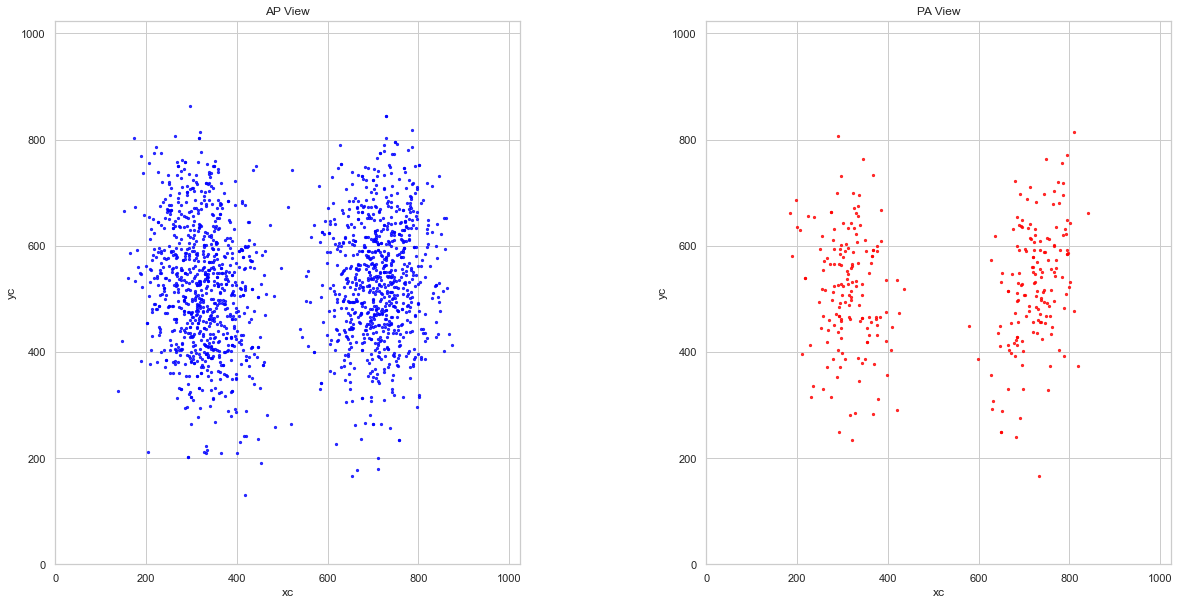

In [39]:
## Scatterplot of different view position
lung_opacity = train_class_dataframe[train_class_dataframe['Target']==1]
target_sample = lung_opacity.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2

target_ap = target_sample[target_sample['ViewPosition']=='AP']
target_pa = target_sample[target_sample['ViewPosition']=='PA']

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

target_ap.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax1, alpha=0.8, marker=".", color="blue",title="AP View")
target_pa.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax2, alpha=0.8, marker=".", color="red",title="PA View")

In [40]:
## Conversion Type
print("Conversion Type : ",train_class_dataframe['ConversionType'].unique())

Conversion Type :  ['WSD']


In [41]:
## Rows
print("Rows : ",train_class_dataframe['Rows'].unique())

Rows :  [1024]


In [42]:
## Columns
print("Columns : ",train_class_dataframe['Columns'].unique())

Columns :  [1024]


In [47]:
## Sex
print("Sex : ",train_class_dataframe['PatientSex'].unique())

Sex :  ['F' 'M']


PatientSex
F    16131
M    21498
Name: PatientSex, dtype: int64


([<matplotlib.patches.Wedge at 0x14c7048cbe0>,
 [Text(-0.2443893411627065, 1.0725082050623476, 'M'),
  Text(0.24438944157817064, -1.0725081821809614, 'F')],
 [Text(-0.1333032769978399, 0.5850044754885532, '57.1%'),
  Text(0.13330333176991124, -0.5850044630077971, '42.9%')])

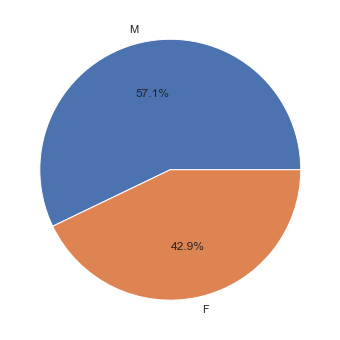

In [50]:
## Distribution of Sex
Sex_count = train_class_dataframe.groupby(['PatientSex'])['PatientSex'].count()
print(Sex_count)
plt.pie(train_class_dataframe['PatientSex'].value_counts(), labels=['M', 'F'], autopct='%1.1f%%')

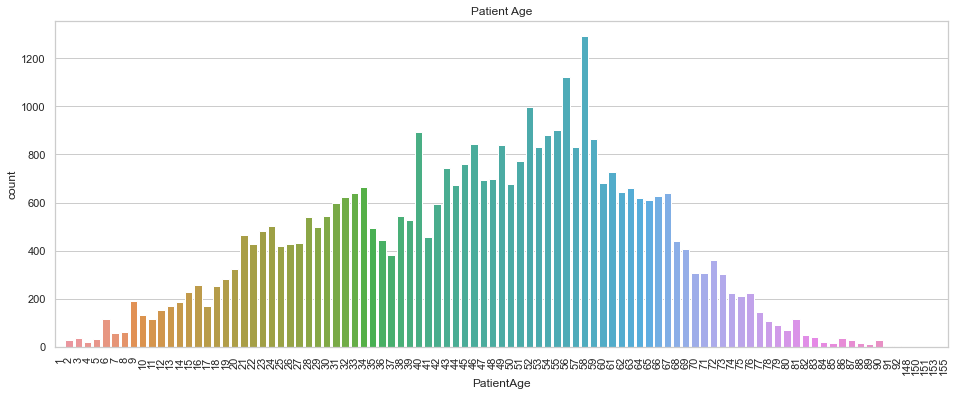

In [51]:
## Patient Age
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(train_class_dataframe['PatientAge'], ax=ax)
plt.title("Patient Age")
plt.xticks(rotation=90)
plt.show()

### H. Complete Profiling of Data

In [54]:
pandas_profiling.ProfileReport(train_class_dataframe)

### Observations of basic exploration of dicom data -

* Size of all images is 1024x1024 (rows and columns are constant)
* Male patients are more than Female patients
* Mean patient age is 46.5 years
* Modaility ,BodyPartExamined ,ConversionType are constant and can be ignored
* Age range between 148 to 155 are surely mistake



### I. DICOM Data - Further Exploration of Variables

In [55]:
## information of the datset , type of columns
train_class_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patientId         37629 non-null  object 
 1   x                 16957 non-null  float64
 2   y                 16957 non-null  float64
 3   width             16957 non-null  float64
 4   height            16957 non-null  float64
 5   Target            37629 non-null  int64  
 6   class             37629 non-null  object 
 7   Modality          37629 non-null  object 
 8   PatientAge        37629 non-null  int64  
 9   PatientSex        37629 non-null  object 
 10  BodyPartExamined  37629 non-null  object 
 11  ViewPosition      37629 non-null  object 
 12  ConversionType    37629 non-null  object 
 13  Rows              37629 non-null  int64  
 14  Columns           37629 non-null  int64  
 15  PixelSpacing      37629 non-null  object 
dtypes: float64(4), int64(4), object(8)
memor

In [104]:
## Creating dataframe for further analysis - removing columns not required
train_class_dataframe_analysis = train_class_dataframe[['patientId','Target','class','PatientAge','PatientSex','ViewPosition','x','y','height','width']]

## Removing duplicated in this analysis table
train_class_dataframe_analysis.drop_duplicates(subset='patientId', keep='first')
train_class_dataframe_analysis.sample(5)

patientId  Target  \
37046  25c915e6-1b94-43b5-a19f-21931faac3b2       1   
3105   309f54b5-d865-4fa9-a827-a2d567cef1b4       0   
13119  6f3ee2c1-3491-4e1e-890f-ffab242b68a7       0   
23994  b3026aa2-14f4-4648-9261-c114f149f0d3       1   
10265  5a8e51d4-1b33-45b3-8f96-5a4027462cbc       1   

                              class  PatientAge PatientSex ViewPosition  \
37046                  Lung Opacity          67          M           AP   
3105   No Lung Opacity / Not Normal          55          F           PA   
13119                        Normal          61          F           PA   
23994                  Lung Opacity          58          M           AP   
10265                  Lung Opacity          73          M           AP   

           x      y  height  width  
37046  621.0  548.0   102.0  204.0  
3105     NaN    NaN     NaN    NaN  
13119    NaN    NaN     NaN    NaN  
23994  198.0  300.0   523.0  232.0  
10265  124.0  258.0   457.0  183.0

In [92]:
## Creating a function to check all correlations

## count - Refers to the examinations for each class detected


def correlation_barplot(df,var1,hue1,rot=0,fig_size=6) :
    tab1 = df.groupby([var1,hue1])['patientId'].count()
    tab2 = pd.DataFrame(data={'count': tab1.values}, index=tab1.index).reset_index()
    tab3 = tab2.groupby(['count',var1,hue1]).count()
    tab4 = pd.DataFrame(data=tab3.values, index=tab3.index).reset_index()
    fig, (ax) = plt.subplots(nrows=1,figsize=(fig_size,fig_size))
    sns.barplot(ax=ax, x = var1, y='count', hue=hue1,data=tab4)
    plt.xticks(rotation=rot)
    plt.title(print("Plot of : ",var1," & ",hue1))
    plt.show()
    

Plot of :  class  &  PatientSex


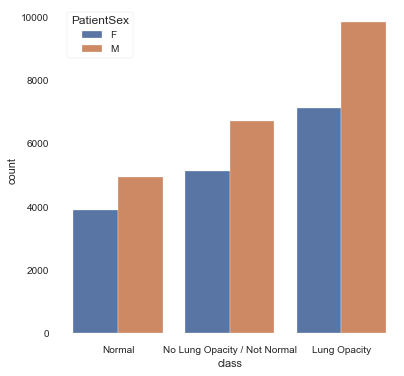

In [93]:
## Class by PatientSex
correlation_barplot(train_class_dataframe_analysis,'class', 'PatientSex')

Plot of :  Target  &  PatientSex


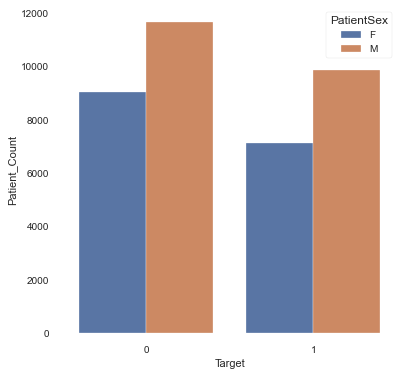

In [75]:
## Target by PatientSex
correlation_barplot(train_class_dataframe_analysis,'Target', 'PatientSex')

Patientsex is distributed equally across all the 3 classes / 2 Targets

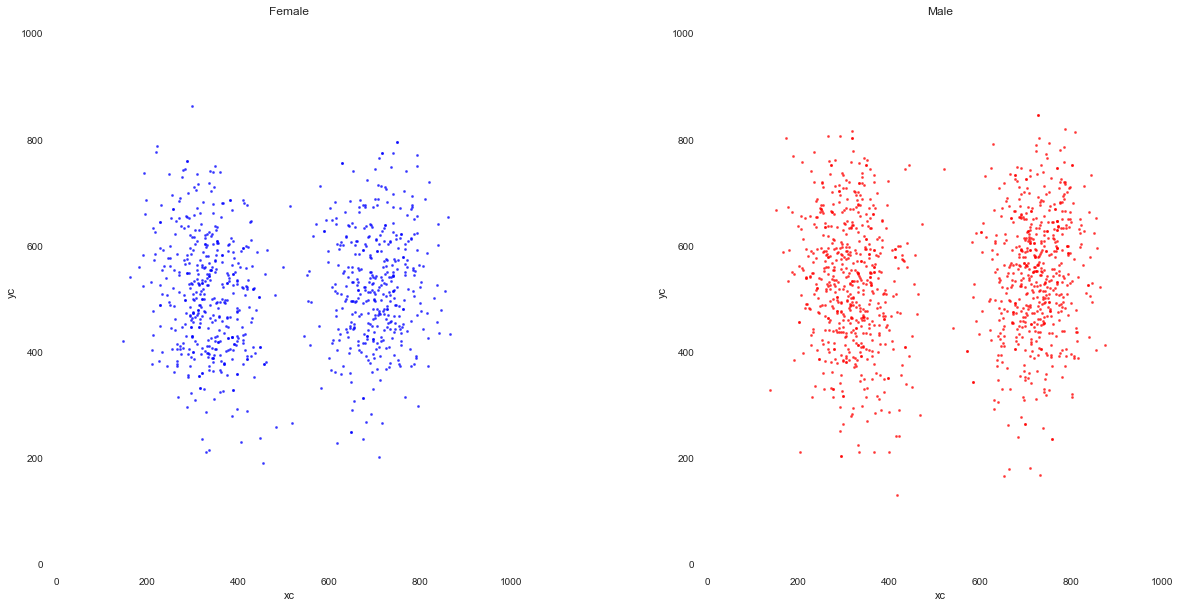

In [67]:
## distribution of window with Lung Opacity, separatelly for the female and male patients for patients with penumonia

target_female = target_sample[target_sample['PatientSex']=='F']
target_male = target_sample[target_sample['PatientSex']=='M']

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

target_female.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax1, alpha=0.8, marker=".", color="blue",title="Female")
target_male.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax2, alpha=0.8, marker=".", color="red",title="Male")

In [106]:
## To further analyse patient age, we need to categorise age in 5 different bins.
## Adding column age_group in the data meant for analysis - train_class_dataframe_analysis

bins= [1,20,35,50,65,80,200]
labels = ['<20','20 to 35','35 to 50','50 to 65','65 to 80','>80']
train_class_dataframe_analysis['AgeGroup'] = pd.cut(train_class_dataframe_analysis['PatientAge'], bins=bins, labels=labels, right=False)

train_class_dataframe_analysis.sample(5)

C:\Users\DoH\Anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


patientId  Target  \
25567  ba06c828-df8c-4c6f-a869-b3ea7d1991cd       1   
13090  6f27fe76-2a4b-4679-8381-664160325373       0   
7681   47f2c736-72d5-4897-b0c7-7119f0fd88c7       1   
19152  961da0cb-cf97-487b-8e59-a07b4fff6c2e       1   
16255  83c485a7-1c15-481f-beee-021f912e9903       0   

                              class  PatientAge PatientSex ViewPosition  \
25567                  Lung Opacity          49          F           AP   
13090                        Normal          39          F           PA   
7681                   Lung Opacity          28          M           AP   
19152                  Lung Opacity          54          F           AP   
16255  No Lung Opacity / Not Normal          58          M           AP   

           x      y  height  width  AgeGroup  
25567  196.0  155.0   503.0  227.0  35 to 50  
13090    NaN    NaN     NaN    NaN  35 to 50  
7681   216.0  225.0   571.0  307.0  20 to 35  
19152  603.0  129.0   676.0  286.0  50 to 65  
16255    NaN    NaN     NaN    NaN  50 to 65

Plot of :  Target  &  AgeGroup


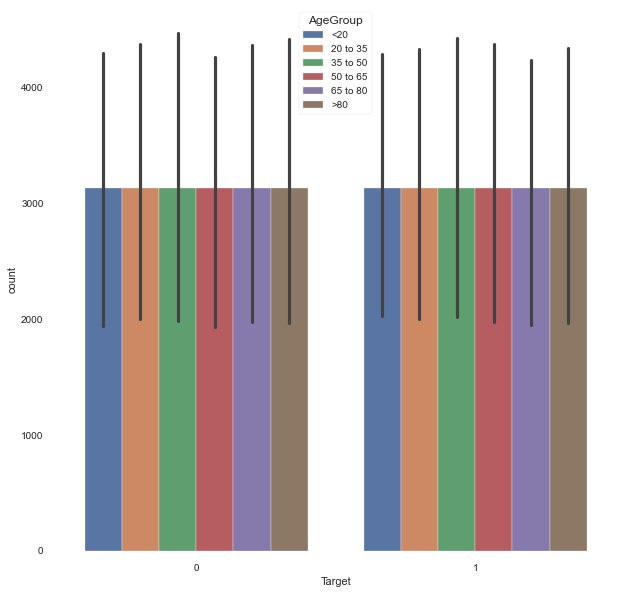

In [99]:
correlation_barplot(train_class_dataframe_analysis,'Target', 'AgeGroup',0,10)

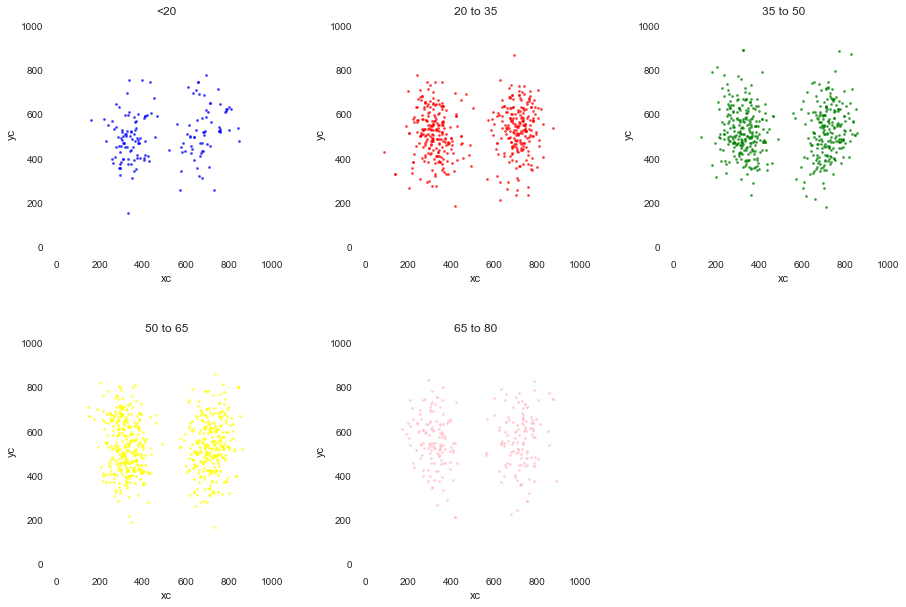

In [114]:
## distribution of window with Lung Opacity, separatelly by age group for patients with penumonia

lung_opacity = train_class_dataframe_analysis[train_class_dataframe['Target']==1]
target_sample = lung_opacity.sample(2000)

target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2

target_0 = target_sample[target_sample['AgeGroup']==labels[0]]
target_1= target_sample[target_sample['AgeGroup']==labels[1]]
target_2= target_sample[target_sample['AgeGroup']==labels[2]]
target_3= target_sample[target_sample['AgeGroup']==labels[3]]
target_4= target_sample[target_sample['AgeGroup']==labels[4]]

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)


target_0.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax0, alpha=0.8, marker=".", color="blue",title=labels[0])
target_1.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax1, alpha=0.8, marker=".", color="red",title=labels[1])
target_2.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax2, alpha=0.8, marker=".", color="green",title=labels[2])
target_3.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax3, alpha=0.8, marker=".", color="yellow",title=labels[3])
target_4.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax4, alpha=0.8, marker=".", color="pink",title=labels[4])

### J. Exploring Images - Creating Bounding Boxes

In [127]:
## Show image with differnet color bounding boxes

# Function to show to a sample image with overlayed bounding box 
def image_check(df):

    imagePath = os.path.join(image_train_path,df['patientId']+'.dcm')
    datarowimg = dcm.read_file(imagePath)
    image = datarowimg.pixel_array
    image = np.stack([image] * 3, axis=2)

    if df['Target'] == 1:        
        image = box_draw(image, df)

    plt.imshow(image, cmap=plt.cm.gist_gray)
    
    
def box_draw(img, df):
    clr = np.floor(np.random.rand(3) * 256).astype('int')
    stroke=14
  
    x1 = int(df['x'])
    y1 = int(df['y'])
    y2 = y1 + int(df['height'])
    x2 = x1 + int(df['width'])
    
    img[y1:y1 + stroke, x1:x2] = clr
    img[y2:y2 + stroke, x1:x2] = clr
    img[y1:y2, x1:x1 + stroke] = clr
    img[y1:y2, x2:x2 + stroke] = clr

    return img

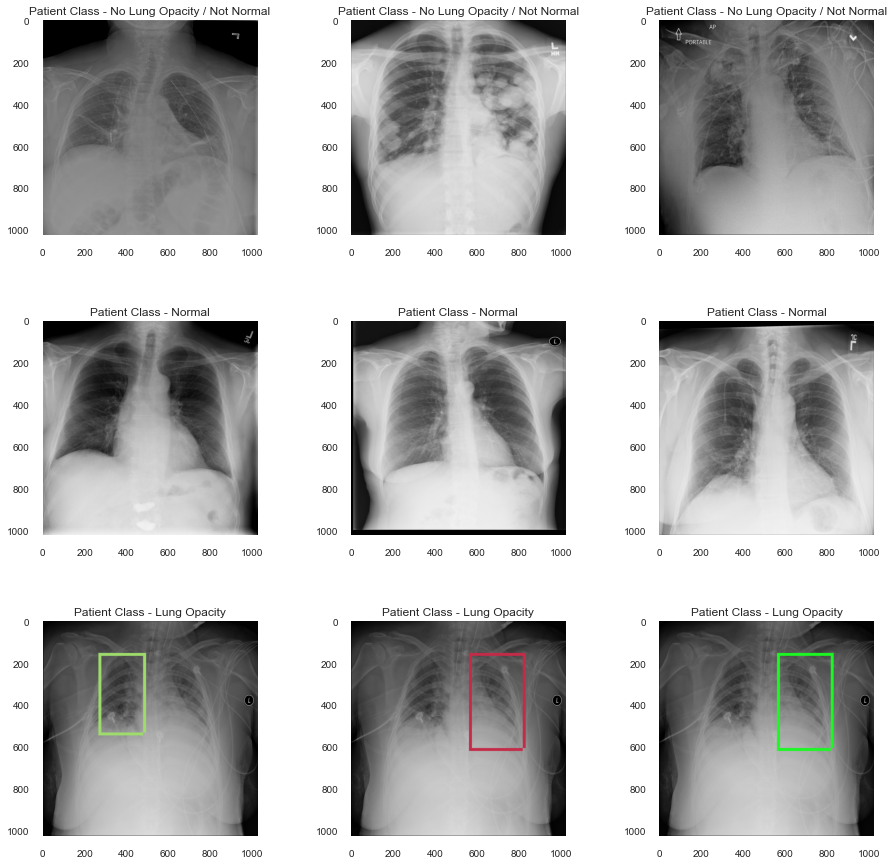

In [133]:
## Check sample images of patient
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

unique_class = train_class_dataframe['class'].unique()
ind = 1
axes=[]

for i in range(len(unique_class)) :
    table_1 = train_class_dataframe[train_class_dataframe['class']==unique_class[i]]
    for x in range(3) :        
        axes.append(fig.add_subplot(3,3,ind))
        ind=ind+1
        patient = list(table_1.T.to_dict().values())[x+1]
        subplot_title=("Patient Class - "+patient['class'])
        axes[-1].set_title(subplot_title)
        image_check(patient)
        

In [138]:
## Show more than 1 bounding boxx in an image with Target =1 

## Define a funtion to parse data and bring all cordinates of single patient id together

def image_with_box(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,16))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(image_train_path,patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\n Target: {}\n Class: {}'.format(data_row['patientId'], data_row['Target'], data_row['class']))
        rows = train_class_dataframe[train_class_dataframe['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()


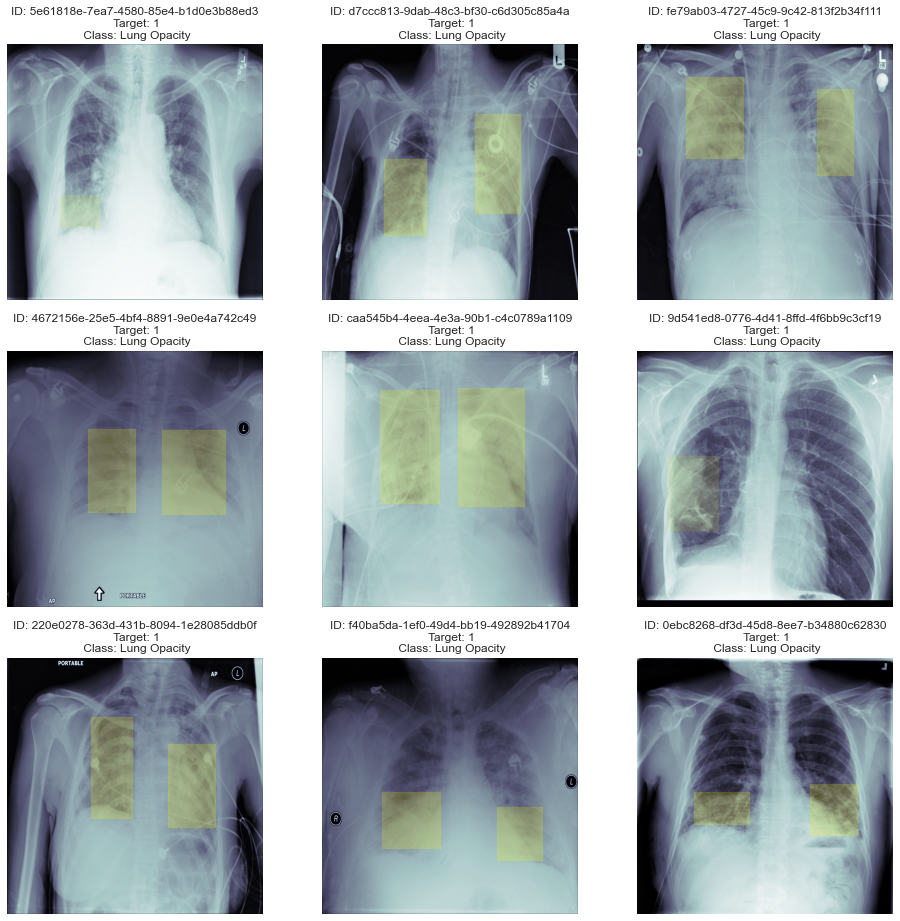

In [139]:
image_with_box(train_class_dataframe[train_class_dataframe['Target']==1].sample(9))

# III Model Approach

The aim of the project is to locate lung opacities on chest readiographs and identify if a patient is suffering from pneumonia (or not). Lung opacities tend to show up as gray patches on chest X-rays indicating that the area within the patch is occupied by something other than air. In the case of pneumonia, lung opcaities are attributed to the presence of bacteria or fliud in lungs. However, other abnormalities like pulmonary edema or even lung tumor appear as lung opacities. Therefore, it takes a trained radiologist to correctly identify the abnormality associated with different manifestations of lung opacities.

In the given dataset, the training data has 6012 such images (from a total of 22684) that have been classified as pneumonia and labeled, '1'. The rest are 'non-pnuemonia' images which have been labelled as 0. For labels=1, the location of lung opacities have been provided via bounding box corodinates. Based on our EDA, for pneumonia containing images, the number of bounding boxes range from 1 upto a maximum of 3, indicating that there are mutiple locations associated with lung opacities. The task therefore is to localize multiple objects(opacities) in images, hence it would be appropriate to implement suitable Object Classification alogorithims. 

Accordindly, we have implemented three approches:

1. Unet architecture on a MobileNet backbone

    (i) Model trained on all images associated with label=1 (i.e. images with bounding boxes)          
    (ii) Model trained on a subset of images associated with labels 1 and 0 (i.e. images with & without bounding boxes)
    
    
2. Unet architecture on a DenseNet backbone


3. Mask R-CNN 

# V Model Description

## Approach 1: Unet architecture on a MobileNet backbone

### Overview:

This approach involves adopting a segmentation pipeline for object detection. Unet is a popular architecture for image segmentation. In addition, the Mobilenet model has been pretrained on over 1 million images from the ImageNet dataset. Therefore, in this approach we have used Mobilenet as an encoder or feature extractor and upsampled with Unet layers to produce segmentation masks for the input images. Subsequently bounding boxes of objects have been decoded from these segmentation masks.

### Network:
The original X-ray images have a dimension of 1024x1024, these were resized to 224x224 and fed as input to the model. The encoder network downsamples four times to a dimension of 16x16 through a series of convolution and max pool stages whereas the decoder upsamples via transposed convolution inorder to produce the segmented image with the same dimension as the input.

### Results:

#### (i) Model trained on all 6012 images associated with label=1 

- Here the images were split into train and validation set and compiled using Adam optimizer with a learning rate of 0.001. The binary cross entropy loss was monitored with the dice coefficient as the metric of choice. A plot of train and validation loss vs the number of epochs is displayed below:

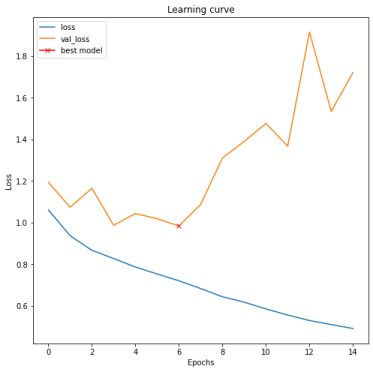

Based on the plot, the train loss decreases with the number of iterations, however the validation loss follows an opposite trajectory. Thus the model appears to be overfitting and requires further tuning. This is discussed in the Future Directions section.

- The validation data was evaluated using the model weights saved during training. This gave a loss of 0.984 and a dice coefficient of 0.557. 

- Below is a sample of an image from the validation set. On the left is the image with the true bounding box coordinates imposed as masks. On the right are the predicted masks. 

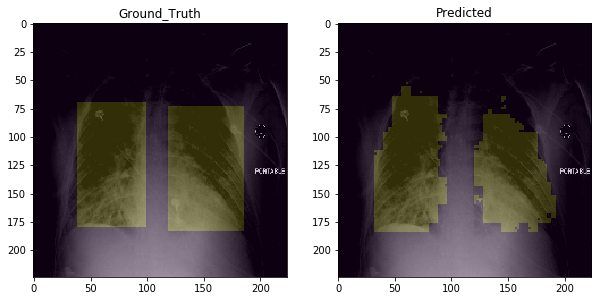

#### (ii) Model trained on  images associated with labels 1 and 0

- In this method the model was trained on a sample of 6000 images equally distributed between labels 1 and 0. The dataset was split into train and validation set in a 80:20 ratio and compiled using Adam optimizer with a learning rate of 0.001. The binary cross entropy loss was monitored with the dice coefficient as the metric of choice. A plot of train and validation loss vs the number of epochs is displayed below.

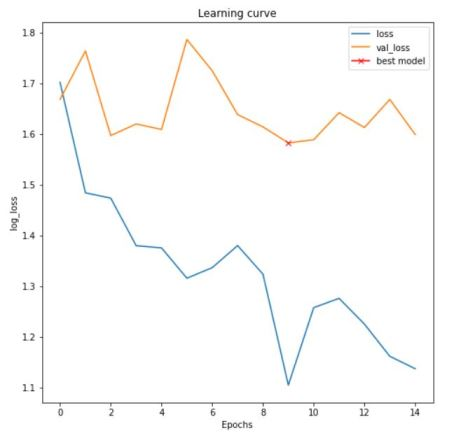

- The validation data was evaluated using model weights which was saved during training. This gave a loss of 0.86 and a dice coefficient of 0.53.

- Below is a sample of an image from the validation set for label=1. On the left is the image with the true bounding box coordinates imposed as masks and on the right are the predicted masks. By observing the images we can see that it almost predicted the boundary boxes for pneumonia.

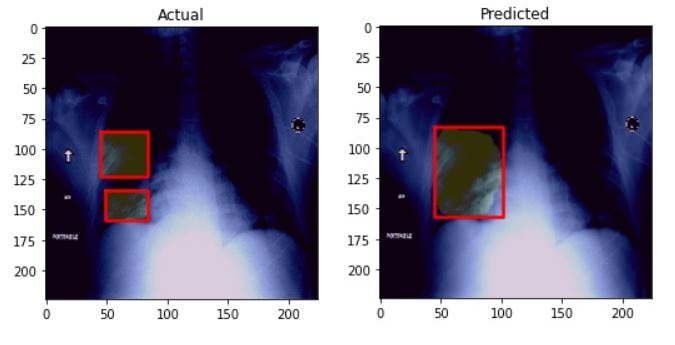

- However, the model also predicts bounding boxes for 'non-pneumonia' images i.e. those with label=0 as shown below. Increasing the prediction threshold appears to resolve this anomaly.

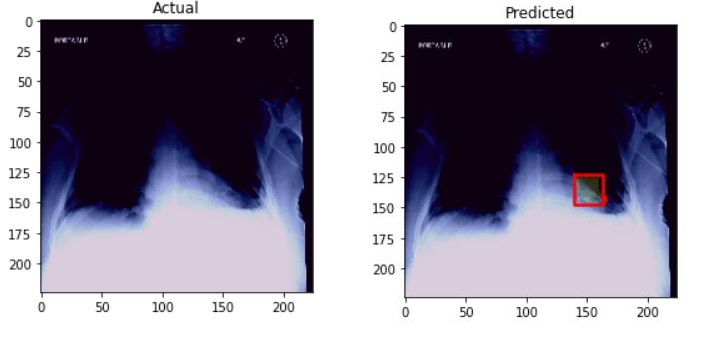

## Approach 2: Unet architecture on a DenseNet backbone

### Overview:

This approach involves adopting a segmentation pipeline for object detection. Unet is a popular architecture for image segmentation. In addition, the DenseNet model has been pretrained on over millions of X-ray images and able to classify 10 different disease from x-ray images. Therefore, in this approach we have used DenseNet as an encoder or feature extractor and upsampled with Unet layers to produce segmentation masks for the input images. Subsequently bounding boxes of objects have been decoded from these segmentation masks.

### Network:
The original X-ray images have a dimension of 1024x1024, these were resized to 224x224 and fed as input to the model. The encoder network downsamples four times to a dimension of 16x16 through a series of convolution and max pool stages whereas the decoder upsamples via transposed convolution inorder to produce the segmented image with the same dimension as the input.

### Results:

####  Model trained on  images associated with labels 1 and 0

- Similar to approach 1, the model was trained on a sample of 6000 images equally distributed between labels 1 and 0. The dataset was split into train and validation set in a 80:20 ratio and compiled using Adam optimizer with a learning rate of 0.001. The binary cross entropy loss was monitored with the dice coefficient as the metric of choice. A plot of train and validation loss vs the number of epochs is displayed below. Again, the model appears to be overfitting and requires further improvement.

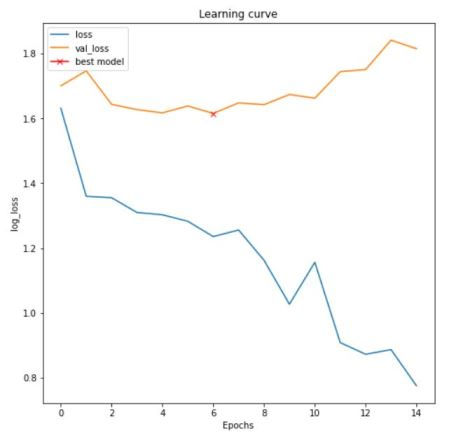

- The validation data was evaluated using model weights which was saved during training. This gave a loss of 1.86 and dice coefficient of 0.46 which is less as compare to the Unet model with MobileNet backbone.

- Below is a sample of an image from the validation set. On the left is the image with the true bounding box coordinates imposed as masks. On the right are the predicted masks for target equal to 1. 

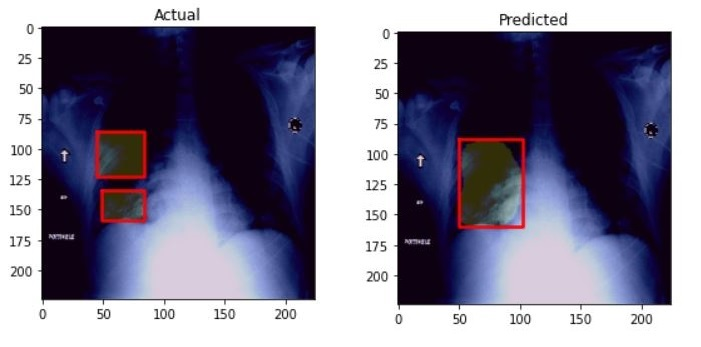

- Similar to the model adopted in approach 1, this model also predicts bounding boxes for 'non-pneumonia' images i.e. those with label=0 as shown below. Since the label=0 is associated with three different classes: 'Normal','Not Normal' and 'No Lung Opcaity, it remains to be seen if the predicted bounding boxes for label=0 might likely be associated with the 'Not-normal' or 'No Lung Opacity' cases.

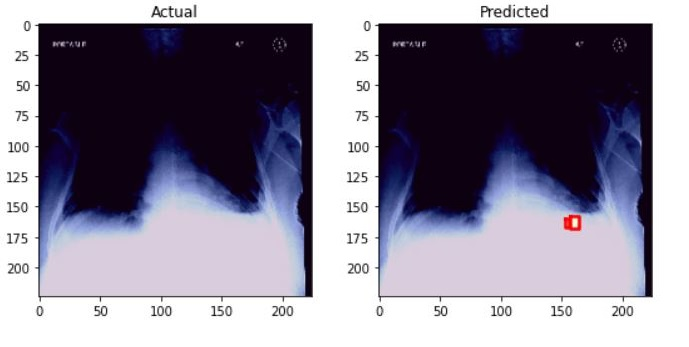

## Approach 3: Mask RCNN on a ResNet50 backbone

### Overview:

Mask RCNN is a meta algorithm applied on Faster- RCNN for instance segmentation and is designed for accuracy rather than memory efficiency. It's not a light-weight model and is a deep neural network for instance segmentation. It predicts the class of the object, refines the bounding box and generates a mask in pixel level of the object based on the input image. It uses Bottom-up pathway -  ResNet, which extracts features from raw images. It uses ROIAlign to locate the relevant areas of feature map, and there is a branch generating masks for each objects in pixel level. Following is the architecture of Mask RCNN

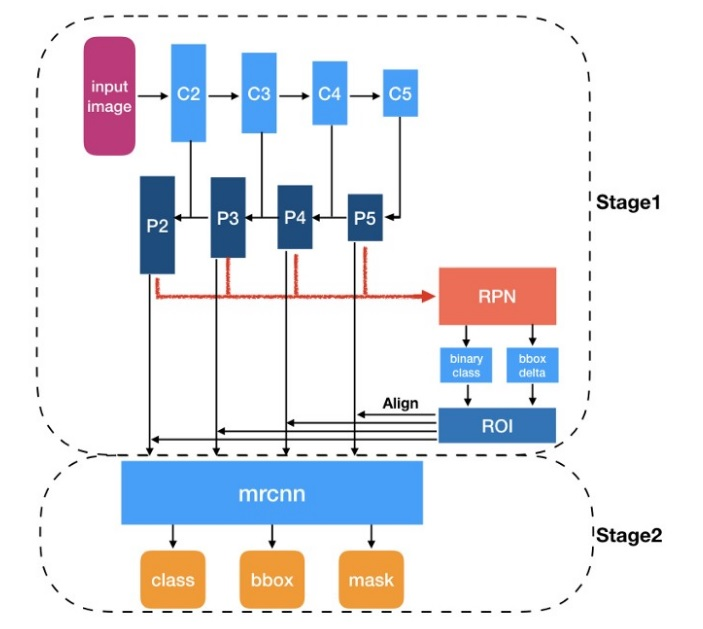

### Network:
The original X-ray images have a dimension of 1024x1024, these were resized to 256x256 and fed as input to the model. Resizing was done to reduce the load on GPU. The image is converted from 256x256 x 3 (RGB) to a feature map of shape 32x32x2048 .Then a convolutional network is used which takes the regions selected by the ROI classifier and generates masks for them. The generated masks are of low resolution- 28x28 pixels. During training, the masks are scaled down to 28x28 to compute the loss, and during inferencing, the predicted masks are scaled up to the size of the ROI bounding box


### Results:

#### (i) Model trained on all 26684 images

- Here the images were split into train and validation set at the 80:20 ratio and compiled with different learning rates. Initially the wieghts are used called COCO Weights which are used with the Matterport Mask RCNN Model in general. 

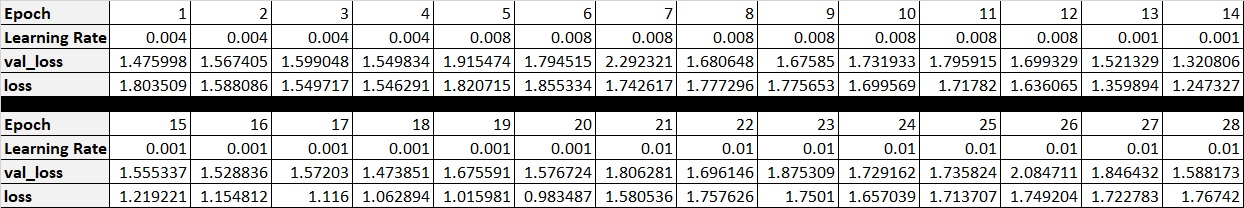

Based on the val loss, it is observed that the lower learning rate yields better results. Epoch 14 yields the lowest val loss value of 1.32 which we use as the further weight to preduct data.  

- Below is a sample of an image from the validation set. On the left is the image with the true bounding box coordinates imposed as masks. On the right are the predicted masks. 

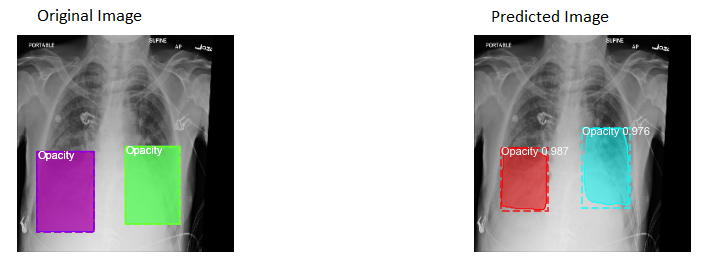



# VI Model Improvements

## Approach I

- For the model trained on labels =1, the trajectory of the loss vs epochs plot suggests that the model may be overfitting. This can be improved by including regularization and dropouts.

- Since the model was not trained on the entire dataset, the next step would be to work in this direction

- Nearly 60% of the images in the dataset are associated with label=0, thus there is bound to be an inherent bias in the model. This can be addressed by implementing data augmentation to expand the  images dataset with labels=1.

## Approach 2

- The model performance can be improved by tuning various hyperparameters like the learning rate, prediction threshold, batch_size and also training it for more epochs.

- Since the Densenet model has been trained on X-ray images, it would be interesting to model the given dataset on various versions of Densenet and compare the performances.


## Approach 3

- Need to reduce the learning rates further to see if it can yield better results
- Need to include other metrics like accuracy
- Currently the model predicts bounding box in normal images as well. Try Increasing the threshold to ensure that there are minimal false positive by guaranteeing that the model predicts only the instances with very high confidence


# VI Summary of Preliminary Results

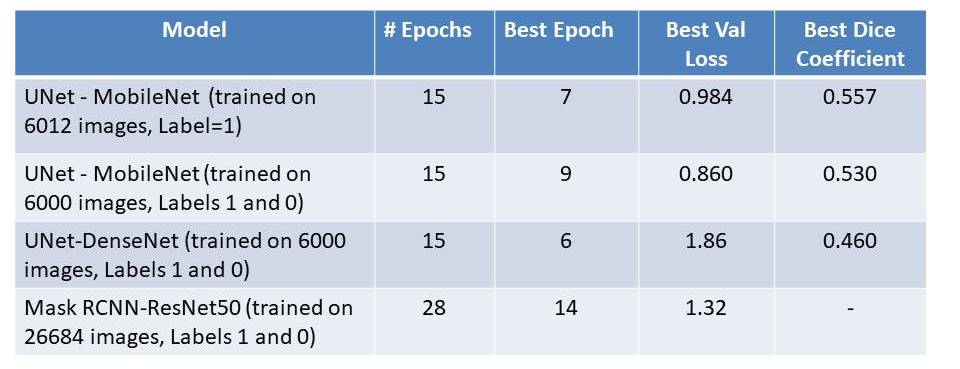